# Anomaly detection after detecting change start point 

In [2]:
%reload_ext autoreload
%autoreload 2

import warnings
import math

import sys
sys.path.append('../')
from tsdr import tsdr
from eval import groundtruth
from tsdr.testseries import sockshop

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import ruptures as rpt

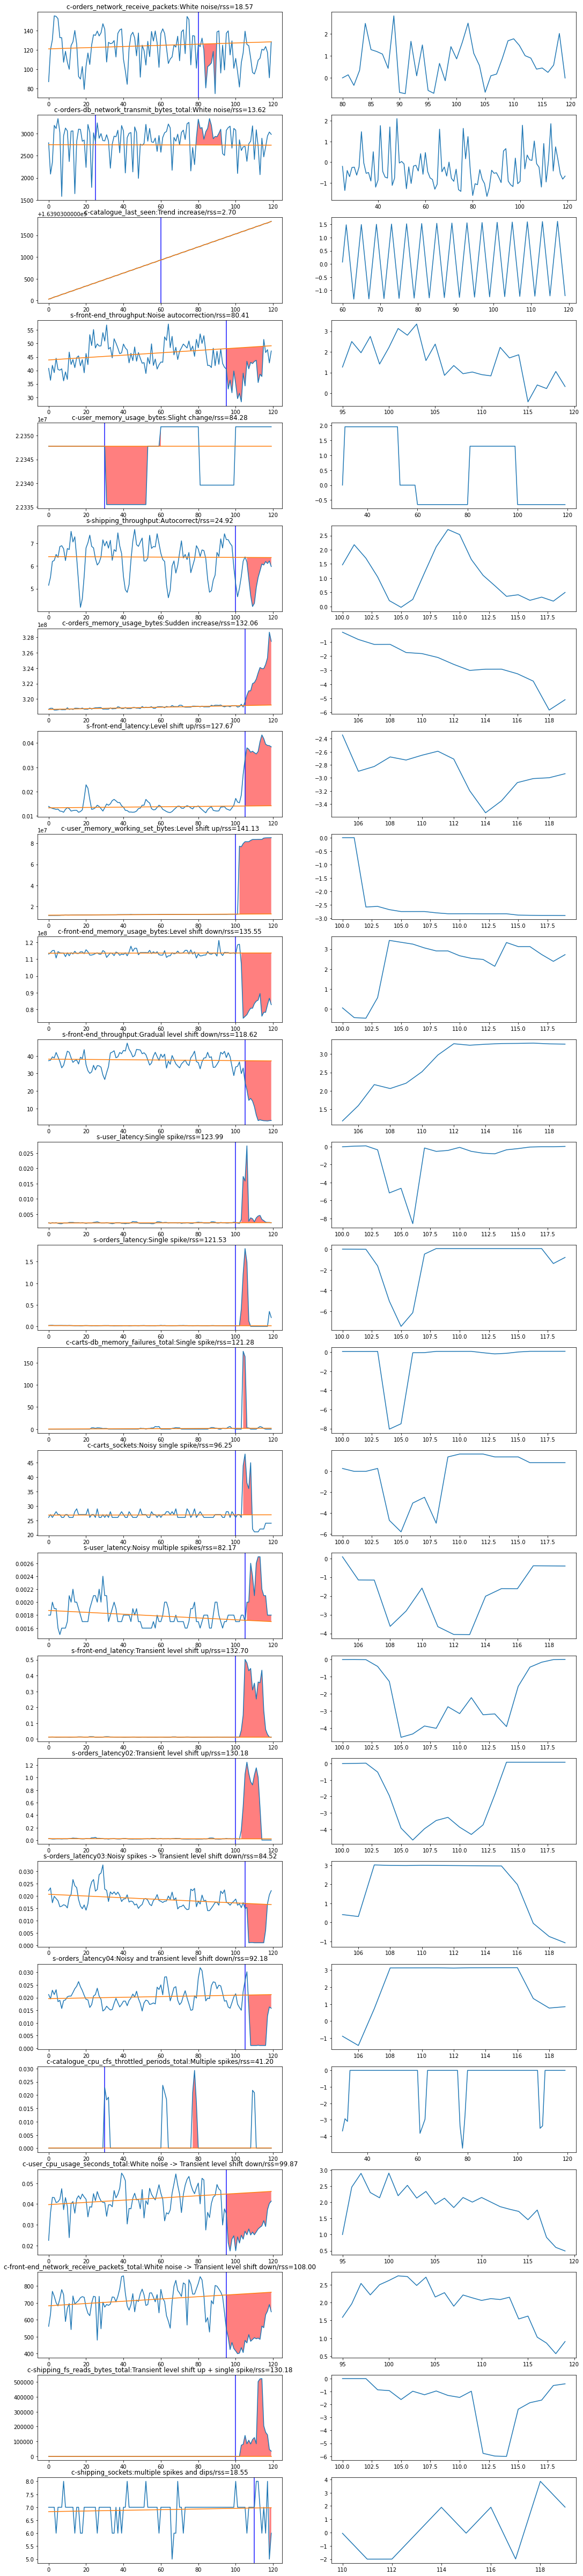

In [14]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

cases = sockshop.testcases_of_sockshop
fig, axs = plt.subplots(math.ceil(len(cases)), ncols=2)
fig.set_size_inches(18, 3.5*len(cases))
for case, ax in zip(cases, axs):
    ts = np.array(case['datapoints'])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        algo = rpt.Binseg(model='normal').fit(ts)

    bkp = algo.predict(n_bkps=1)[0]
    ax[0].axvline(bkp - 0.5, color='k', alpha=0.9, linestyle="--", linewidth=3)

    train_x, test_x = np.split(ts, [bkp])

    ols = OLS(train_x, add_constant(np.arange(1, train_x.size+1))).fit()
    preds = ols.predict(exog=add_constant(np.arange(train_x.size+1, ts.size+1)))
    errors = preds - test_x
    total_preds = np.append(ols.predict(), preds)
    resid_and_errors = total_preds - ts
    std = resid_and_errors.std()
    errors = errors / std
    ax[1].plot(np.append(np.full_like(train_x, np.NaN), errors))

    intersected_idxs: np.ndarray = np.where(np.diff(np.sign(errors)))[0] + 1
    sections = np.split(errors, indices_or_sections=intersected_idxs)
    rsses = np.array([np.sum(errs**2) for errs in sections])
    max_rss_sec_idx: np.intp = np.argmax(rsses)
    max_rss_start: int = 0 if max_rss_sec_idx == 0 else np.sum([sec.size for sec in sections[:max_rss_sec_idx]])
    max_rss: float = rsses[max_rss_sec_idx]
    max_rss_sec: list[tuple[int, float]] = [(max_rss_start+i, v) for i, v in enumerate(sections[max_rss_sec_idx])]

    ax[0].plot(ts)
    ax[0].plot(total_preds)

    max_rss_range = (bkp + max_rss_start, bkp + max_rss_start + sections[max_rss_sec_idx].size + 1)
    xrange = [bkp + t for (t, v) in max_rss_sec]
    # ax.plot(xrange, ts[xrange], 'o') 
    x = np.arange(0, ts.size)
    ax[0].fill_between(x, ts, total_preds, facecolor='red', alpha=0.5, 
        where=((x >= max_rss_range[0]) & (x < max_rss_range[1])))
    ax[0].set_title(f"{case['name']}:{case['pattern']}/rss={max_rss:.2f}")